In [2]:
import pandas as pd
import numpy as np
import random
import data_processing
import models
import plotting

Using TensorFlow backend.


### Load data

In [15]:
chain = 'chain1'
select_epitopes = ['NLVPMVATV', 'GILGFVFTL', 'GLCTLVAML', 'LLWNGPMAV']

sub, other_ep_tcrs = data_processing.load_and_prepare_data(iedb_csv='./data/iedb_HLA-A2_1.csv', chain=chain,
                                           select_epitopes=select_epitopes, show_summary=False, V_and_J_only=False)
if chain == 'full_chain':
    sub = sub[[chain, 'chain1', 'chain2', 'epitope', 'bind', 'set']]
    other_ep_tcrs = other_ep_tcrs[[chain, 'chain1', 'chain2', 'epitope', 'bind', 'set']]
else:
    sub = sub[[chain, 'epitope', 'bind', 'set']]
    other_ep_tcrs = other_ep_tcrs[[chain, 'epitope', 'bind', 'set']]    

### Decide on whether or not to subset the chain1 or chain2 analysis based on what's available for the full_chain analysis.
Looking at the full_chain requires samples that have both alpha and beta sequences. This significantly reduces the number of overall samples.

In [16]:
use_same_tcrs_as_full_chain = False

if use_same_tcrs_as_full_chain:
    ### First run the full_chain analysis and save the alpha and beta chains
    if chain == 'full_chain':
        alpha = sub['chain1']
        beta = sub['chain2']
        beta_others = other_ep_tcrs['chain2']
        alpha_others = other_ep_tcrs['chain1']

    ### For chain1 analysis, subset on alpha chains from the full_chain analysis
    elif chain == 'chain1':
        sub = sub[sub[chain].isin(alpha.values)]
        other_ep_tcrs = other_ep_tcrs[other_ep_tcrs[chain].isin(alpha_others.values)]

    ### For chain2 analysis, subset on beta chains from the full_chain analysis
    elif chain == 'chain2':
        sub = sub[sub[chain].isin(beta.values)]
        other_ep_tcrs = other_ep_tcrs[other_ep_tcrs[chain].isin(beta_others.values)]

### Train / test split

In [17]:
dict_of_models = {}

Training samples: 14214 || Testing samples: 4062
Encoding sequences...
Training...
Training samples: 14214 || Testing samples: 4062
Encoding sequences...
Training...
Training samples: 14214 || Testing samples: 4062
Encoding sequences...
Training...
Training samples: 14214 || Testing samples: 4062
Encoding sequences...
Training...
Training samples: 14214 || Testing samples: 4062
Encoding sequences...
Training...
Training samples: 14214 || Testing samples: 4062
Encoding sequences...
Training...
Training samples: 14214 || Testing samples: 4062
Encoding sequences...
Training...


/home/paul/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/paul/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


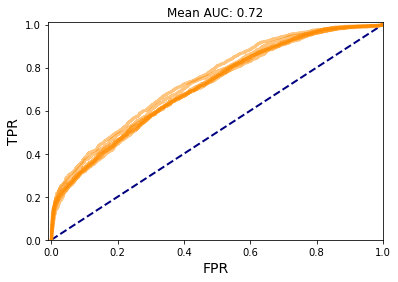

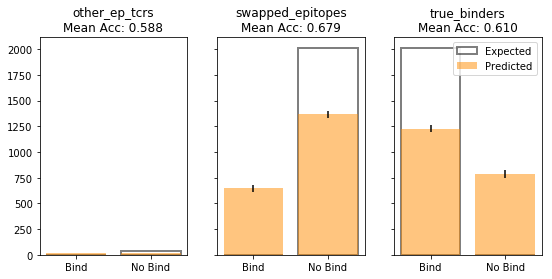

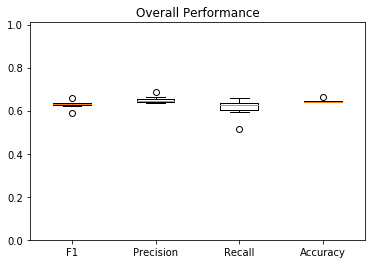

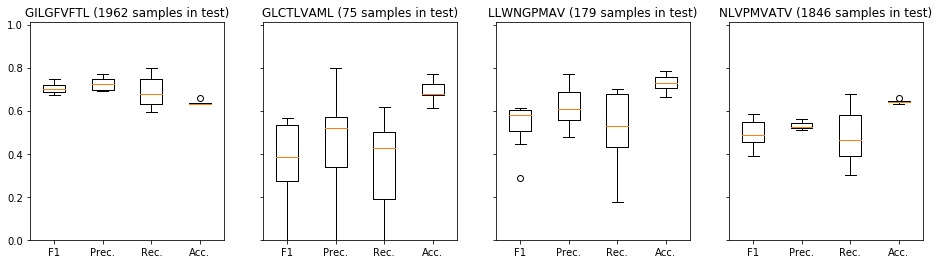

In [18]:
model_results = models.BatchModelResults()
dict_of_models[chain] = model_results

tcr_max_len = sub[chain].str.len().max()
epitopes = sub['epitope']
encoded_epitopes = data_processing.encode_epitopes(sub['epitope'].unique())

for seed in range(20,27):
    train, test = models.train_test_split(sub, classes=sub['epitope'].unique(), chain=chain, class_col='epitope', seed=seed, train_size=0.7)
    other_ep_train, other_ep_test = models.train_test_split(other_ep_tcrs, classes=other_ep_tcrs['epitope'].unique(), chain=chain, class_col='epitope', seed=seed, train_size=0.7)
    
    ### Make synthetic train data, assign false epitopes to 'other_epitopes', combine all train data
    ### Synthetic types: 'swapped_epitopes', 'scrambled_seqs_and_random_eps', 'scrambled_seqs_and_same_eps'
    synthetics_to_make = ['swapped_epitopes', 'scrambled_seqs_and_same_eps']
    synth_train = data_processing.make_synthetic_data(train, chain, epitopes, synthetics_to_make, tile_sequences=False)
    other_ep_train['epitope'] = other_ep_train['epitope'].apply(lambda current_ep: data_processing.swap_epitopes(current_ep, epitopes))
    all_train = pd.concat([train, synth_train, other_ep_train], sort=True)
    all_train = all_train.sample(frac=1.0).reset_index(drop=True)

    
    ### Make synthetic test data, assign false epitopes to 'other_epitopes', combine all test data
    synthetics_to_make = ['swapped_epitopes']
    synth_test = data_processing.make_synthetic_data(test, chain, epitopes, synthetics_to_make)
    other_ep_test['epitope'] = other_ep_train['epitope'].apply(lambda current_ep: data_processing.swap_epitopes(current_ep, epitopes))
    all_test = pd.concat([test, synth_test, other_ep_test], sort=True)
    all_test = all_test.sample(frac=1.0).reset_index(drop=True)

    print('Training samples: {} || Testing samples: {}'.format(len(all_train), len(all_test)))
    

    ### Encode sequences and epitopes
    print('Encoding sequences...')
    scrambled_train_tcrs = all_train[chain].sample(frac=1)
    scrambled_test_tcrs = all_test[chain].sample(frac=1)
    randomized_test_tcrs = all_test[chain].apply(lambda x: data_processing.randomize_seq(x))

    
    ### One hot encode sequences
    train_tcrs = data_processing.encode_seqs(all_train[chain], target_length=tcr_max_len)
    test_tcrs = data_processing.encode_seqs(all_test[chain], target_length=tcr_max_len)
    scrambled_train_tcrs = data_processing.encode_seqs(scrambled_train_tcrs, target_length=tcr_max_len)
    scrambled_test_tcrs = data_processing.encode_seqs(scrambled_test_tcrs, target_length=tcr_max_len)
    randomized_test_tcrs = data_processing.encode_seqs(randomized_test_tcrs, target_length=tcr_max_len)
    
    
    ### One hot encode epitopes
    all_train['oh_ep'] = all_train['epitope'].apply(lambda x: encoded_epitopes[x])
    all_test['oh_ep'] = all_test['epitope'].apply(lambda x: encoded_epitopes[x])
    train_eps = np.vstack(all_train['oh_ep'])
    test_eps = np.vstack(all_test['oh_ep'])

    
    ### Set up class weights - optional
    all_train['weight'] = all_train['bind'].apply(lambda x: 1 if x == 0 else 1)
    class_weights = dict(zip(all_train.index, all_train['weight']))
    
    
    ### Modeling
    print('Training...')
    model, callbacks = models.build_model(train_tcrs, train_eps)
    model.fit([train_tcrs, train_eps], all_train['bind'].values, epochs=20, class_weight=class_weights, validation_split=0.1, callbacks=callbacks, verbose=0)

    
    ### Model evaluation
    all_test['prob'] = model.predict([test_tcrs, test_eps])
    all_test['pred'] = all_test['prob'].apply(lambda x: 1 if x >= 0.5 else 0)
    model_results.add_test_output(all_test)

model_results.plot_all_auroc()
model_results.plot_set_accuracy()
model_results.plot_metrics_boxplots()
model_results.plot_epitope_performance()

### Alpha chain performance

/home/paul/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/paul/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


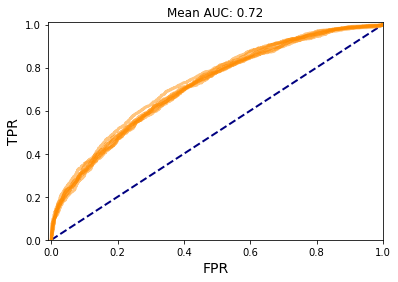

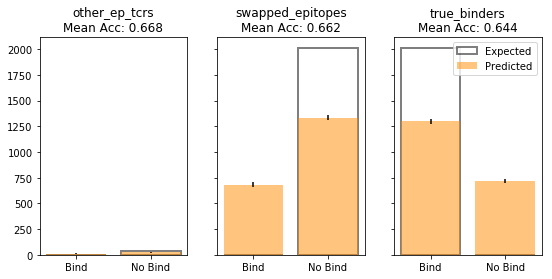

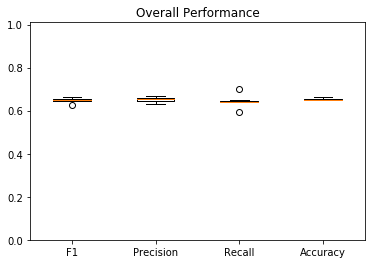

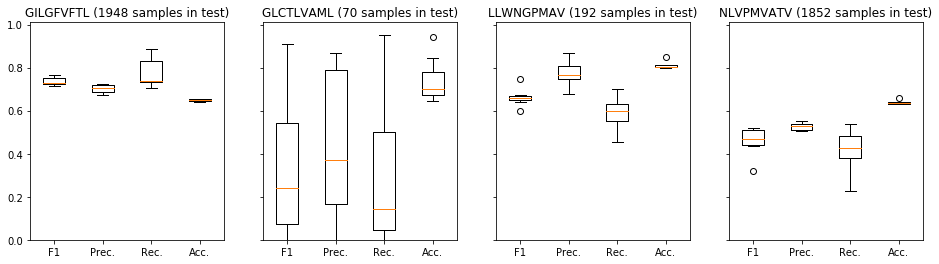

In [8]:
dict_of_models['chain1'].plot_all_auroc()
dict_of_models['chain1'].plot_set_accuracy()
dict_of_models['chain1'].plot_metrics_boxplots()
dict_of_models['chain1'].plot_epitope_performance()

### Beta chain performance

/home/paul/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/paul/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


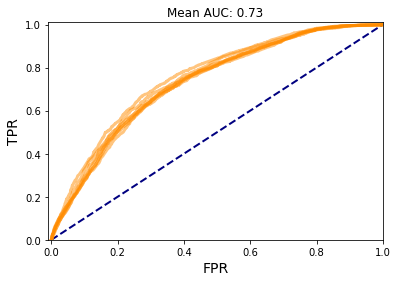

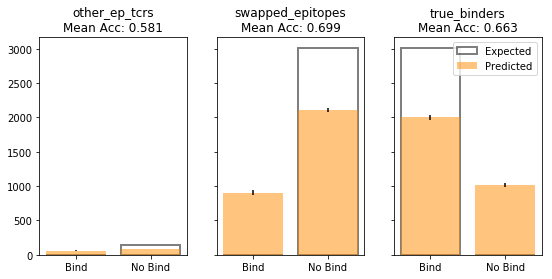

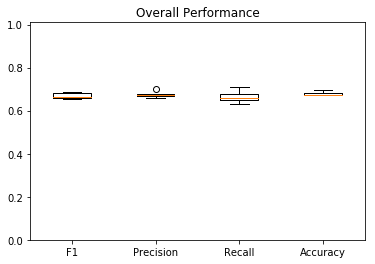

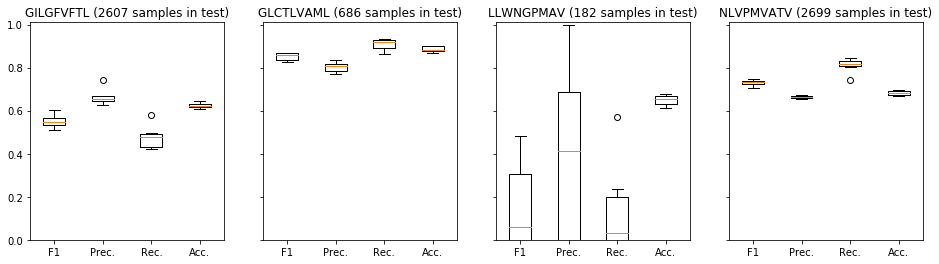

In [13]:
dict_of_models['chain2'].plot_all_auroc()
dict_of_models['chain2'].plot_set_accuracy()
dict_of_models['chain2'].plot_metrics_boxplots()
dict_of_models['chain2'].plot_epitope_performance()

### Full chain performance

/home/paul/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/paul/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


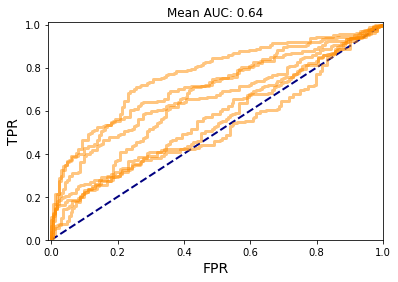

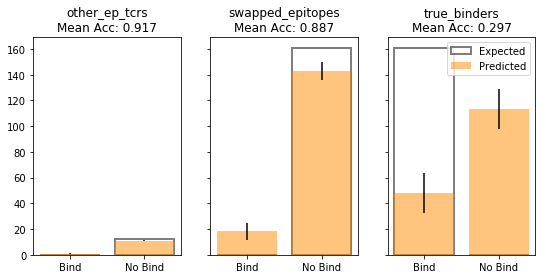

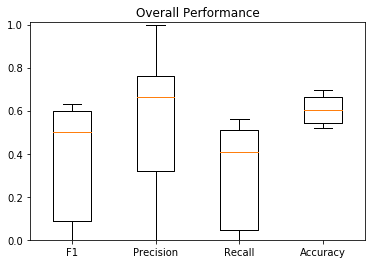

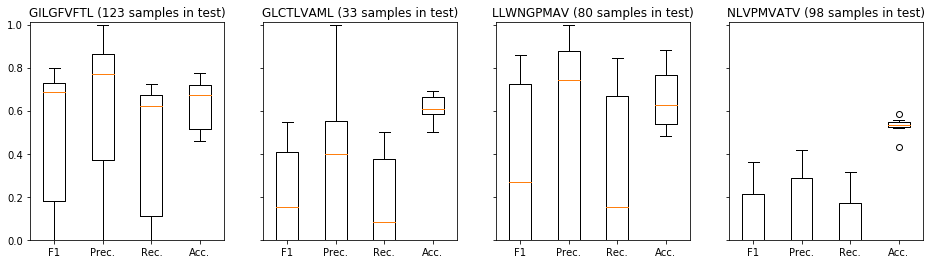

In [7]:
dict_of_models['full_chain'].plot_all_auroc()
dict_of_models['full_chain'].plot_set_accuracy()
dict_of_models['full_chain'].plot_metrics_boxplots()
dict_of_models['full_chain'].plot_epitope_performance()

### Trim ends and test binding prediction

In [23]:
left_acc = []

for i in range(3):
    t = all_test[chain].apply(lambda x: data_processing.subtract_from_ends(x, left_end=i, right_end=0))
    t = data_processing.encode_seqs(t,target_length=tcr_max_len)
    
    tmp_test_eps = data_processing.encode_epitopes(all_test['epitope'])
    tmp_test_eps = np.vstack(tmp_test_eps)
    
    pred = model.predict([t, tmp_test_eps])
    pred_binary = convert2binary(pred)

    left_acc.append(accuracy_score(all_test['bind'], pred_binary))
    
right_acc = []

for i in range(3):
    t = all_test[chain].apply(lambda x: data_processing.subtract_from_ends(x, left_end=0, right_end=i))
    t = data_processing.encode_seqs(t,target_length=tcr_max_len)
    
    tmp_test_eps = data_processing.encode_epitopes(all_test['epitope'])
    tmp_test_eps = np.vstack(tmp_test_eps)
    
    pred = model.predict([t, tmp_test_eps])
    pred_binary = convert2binary(pred)

    right_acc.append(accuracy_score(all_test['bind'], pred_binary))
    
both_acc = []

for i in range(3):
    tq = all_test[chain].apply(lambda x: data_processing.data_processing.subtract_from_ends(x, left_end=i, right_end=i))
    t = data_processing.encode_seqs(tq,target_length=tcr_max_len)
    
    tmp_test_eps = data_processing.encode_epitopes(all_test['epitope'])
    tmp_test_eps = np.vstack(tmp_test_eps)
    
    pred = model.predict([t, tmp_test_eps])
    pred_binary = convert2binary(pred)

    both_acc.append(accuracy_score(all_test['bind'], pred_binary))

ValueError: Error when checking input: expected input_46 to have shape (4,) but got array with shape (1,)

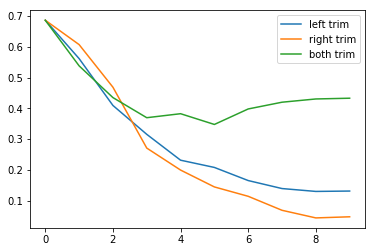

In [38]:
f, ax = plt.subplots()
ax.plot(left_acc, label='left trim')
ax.plot(right_acc, label='right trim')
ax.plot(both_acc, label='both trim')
ax.legend()

### Plot model architecture

In [8]:
models.plot_model(model, to_file='./images/model_architecture.png', show_layer_names=False, rankdir='LR')